<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
#from sklearn import DBSCAN
import warnings
warnings.filterwarnings("ignore")
import os
import random
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# Load SHAP_ERROR_DATA

In [2]:
Shap_error_data = pd.read_csv('/content/Shap_error_data.csv')
#Shap_error_data.info()
features = Shap_error_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP'], axis=1)

In [3]:
#print(Shap_error_data.loc[3])

In [4]:
#print(Shap_error_data.isna().sum())
len(Shap_error_data.index)

5050

# Preprocessing: Initialize / scaling dataset

In [5]:
def initialize_dataset (raw_data, with_errors = True, just_features = True, scale_features = True, with_classes = True):
  #input is the original dataset, whether errors are included, only features should be used, to scale the features, class labels are included
  #Initialisation of the dataset. Scales the features and errors, which can be included or exluded for clustering
  #it returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which is required for HBAC

  new_data = raw_data.copy(deep=True)

  if with_errors:
    scaling_factor = 0.8  # default scaling factor - there is a trade-off between scaling of weighing the errors to guide biased clusters while preventing too large and uninformative clusters
    new_data['scaled_TP'] = new_data['TP'] * scaling_factor
    new_data['scaled_TN'] = new_data['TN'] * scaling_factor
    new_data['scaled_FN'] = new_data['FN'] * scaling_factor
    new_data['scaled_FP'] = new_data['FP'] * scaling_factor

  if just_features:
    new_data = new_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP'], axis=1)

  if scale_features:
    to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP'], axis=1).columns
    new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])

  if with_classes:
    for col in ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP']:
      new_data[col] = raw_data[col]


    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
  return new_data

## Clustering on either TP/FN or TN/FP --> drop 0,0 columns

In [6]:
##Drop rows where both TP and FN are zero
def drop_zero_TP_FN(data):
  return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

TP_FN_data = drop_zero_TP_FN(Shap_error_data)

################################################

#Drop rows where both TN and FP are zero
def drop_zero_TN_FP(data):
  return data.loc[(data['TN']  == 1 ) | (data['FP'] == 1)]

TN_FP_data = drop_zero_TN_FP(Shap_error_data)

################################################
if ((TP_FN_data['TP'] == 0) & (TP_FN_data['FN'] == 0)).any():
    print("There's at least one occurrence of TP 0 and FN 0 in the dataset.")
else:
    print("There's no occurrence of 0,0 in both columns TP and FN.")

if ((TN_FP_data['TN'] == 0) & (TN_FP_data['FP'] == 0) ).any():
    print("There's at least one occurrence of TP 0 and FN 0 in the dataset.")
else:
    print("There's no occurrence of 0,0 in both columns TN and FP.")

There's no occurrence of 0,0 in both columns TP and FN.
There's no occurrence of 0,0 in both columns TN and FP.


In [7]:
len(TP_FN_data)
#len(TN_FP_data)
#len(Shap_error_data)

1579

# PCA
needs to be separated still for TN/FP and TP/FN

In [8]:
def pca_plot(data, title, alpha):

    #extract features for PCA and drop the other columns in other_features df
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type']]

    # Scale the PCA features before using PCA
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)

    #create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    scatterplot = sns.scatterplot(data=temp_dataset,x ='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type", palette="tab10", style="Error_Type")

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()


#Clustering Functions

In [9]:
#Calculate accuracy on error
def accuracy_error (results):
  if len(results) == 0:
    print ("you are calculating the accuracy on an empty cluster")
  correct = results.loc[results['error'] == 0]
  acc = len(correct)/ len(results)
  return acc

#################################

#Calculate bias based on accuracy_error function

'''Calculate bias: negative bias as the accuracy of a selected cluster - accruacy of the remaining clusters
 Colster col: name of the DF column where the cluster assignments are'''

def bias_w_error (data, cluster_id, cluster_col):
  cluster_x = data.loc[data[cluster_col] == cluster_id]
  if len(cluster_x) ==0:
    print("this is an empty cluster", cluster_id)
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]
  if len(remaining_clusters) ==0:
    print ("This cluster is the entire dataset. Cluster:", cluster_id)
  return accuracy_error(cluster_x) - accuracy_error(remaining_clusters)

#################################

#Combined function for get_max_neg_bias and get_max_pos_bias

def get_max_bias(fulldata, bias_type = 'negative', function = bias_w_error):
  max_bias = float('inf') if bias_type == 'negative' else -float('inf') #initializes max_bias with either positive of negative infinity (special floating point value) based on bias_type param
  for cluster_number in fulldata['new_clusters'].unique():
    if cluster_number == -1:#outliers in dbscan
      continue
    current_bias = function(fulldata, cluster_number, 'new_clusters') #for each cluster the bias_w_error function is calculated
    if (bias_type == 'negative' and current_bias < max_bias) or (bias_type == 'positive' and current_bias > max_bias):
      max_bias = current_bias
  print(f'Maximum {bias_type} bias is:', max_bias)
  return max_bias


###################################
#get max bias cluster --> returns a cluster with neg bias (for newly added clusters)

def get_cluster_max_bias(fulldata, function = bias_w_error):
  max_pos_bias = 100 #max_abs bias selma code
  max_bias_cluster = -2
  for cluster_number in fulldata['clusters'].unique():
    if cluster_number == -1:
      continue
    current_bias = (function(fulldata, cluster_number, 'clusters')) #pos function to find the highest bias
    print(f"{cluster_number} has bias {current_bias}")
    if current_bias < max_pos_bias:
      max_pos_bias = current_bias
      max_bias_cluster = cluster_number
  print ('cluster with the highest discriminating bias:', max_bias_cluster)
  return max_bias_cluster

#################################

#Select a new cluster to split on based on the smallest absolute difference from the overall error rate of 0.5
#Function requires a df.columns named 'clusters' and 'FP'

def select_new_cluster(data, error_column='FP', overall_error_rate=0.5):
  smallest_diff = 1
  cluster_number = 0

  for cluster_number in data['clusters'].unique():
    if cluster_number == -1:
      continue
    cluster_data = data[data['clusters'] == cluster_number]
    cluster_error_rate = cluster_data([error_column]).mean()
    abs_diff = abs(overall_error_rate - cluster_error_rate)

    if abs_diff < smallest_diff:
      smallest_diff = abs_diff
      selected_cluster = cluster_number

  return selected_cluster

#############################################
#Calculate variance

def calculate_variance(data):
  variance_list_local = []
  for j in data['clusters'].unique():
    average_acc = accuracy_error(data)
    bias_clus = bias_w_error(data, j, 'clusters')
    variance_list_local.append(bias_clus)
  variance = np.variance(variance_list_local)
  return variance

#calculate bias_acc_global

def calculate_bias_global_average(data, cluster_id, cluster_col, ave_acc):
  cluster_x = data.loc[data[cluster_col] == cluster_id]
  return accuracy_error(cluster_x) - ave_acc

#############################################

#Get min splittable cluster size - returns size of smallest new cluster
def min_split_cluster_size(data):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1:
      continue
    size = len(data.loc[data['new_clusters']==i])
    if size < min_cluster_size:
      min_cluster_size = size
  return min_cluster_size

#################################################


#Select a random cluster from provided list of clusters that is not -1
def get_random_cluster(clusters):
  result = -1
  while (result == -1):
    result = random.randint(0, len(clusters.unique()))
  print('This is the random cluster we picked:', result)
  return result

#############################################

#Plot cluster
def plot_clusters(data):
  scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size = 'errors', sizes=(100, 20), palette = "tab10")
  plt.show()


In [10]:
round(0.02 * len(TN_FP_data)) #decide on min nr points for dbscan?

39

In [11]:
round(0.02 * len(TP_FN_data))

32

# Determining the epsilon parameter using the K-Distance plot

Using the k-distance plot to determine epsilon by identifying the knee point (where there is a significant increese

Text(0.5, 1.0, 'Optimal Value of Epsilon for COMPAS')

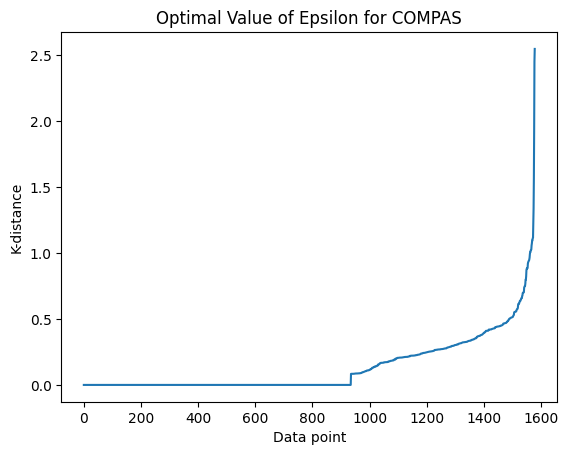

In [13]:
nn_features = TP_FN_data.iloc[:, : 11]

neigh = NearestNeighbors(n_neighbors = 3) # compute distance to 2nd nearest neighbor (k=3) for each data point
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis= 0)
distances = distances [:,1]
plt.plot(distances)
plt.xlabel('Data point')mi
plt.ylabel('K-distance')
plt.title("Optimal Value of Epsilon for COMPAS")

Determining the number of custers using Silhouette Score and Covariance of Variation: psuedo code from Nasiriani et al (algorithm 2: cluster number finder) is not needed for dbscan

In [ ]:
'''
M = 10  # Example value for M
t = 0.1  # Example value for t

def Cluster_number(data):
    k = 2
    num_clusters = 2
    CoV_final = -np.inf

    while k <= M:
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k)
        clusters = kmeans.fit_predict(data)

        # Compute Silhouette score for each cluster
        silhouette_vals = silhouette_samples(data, clusters)

        # Calculate Silhouette coverage for each cluster
        silcov = np.zeros(k)
        for i in range(k):
            sili = silhouette_vals[clusters == i]
            if np.std(sili) <= t:
                silcov[i] = t / np.mean(sili)
            else:
                silcov[i] = np.std(sili) / np.mean(sili)

        # Calculate Coefficient of Variation
        CoV_n = np.std(silcov) / np.mean(silcov)

        # Update number of clusters if CoVn is smaller or equal to CoVfinal
        if CoV_n <= CoV_final:
            num_clusters = k
            CoV_final = CoV_n

        k += 1

    return num_clusters
    '''

#DBSCAN clustering

In [14]:
eps = 0.5 #from K-distance plot?
min_samples = 39 # minPts minimum neighbors to consider a point as core point - 2*dim - round(0.02 * len(TN_FP_data))
variance_list = []
x = 0 #cluster number
initial_bias = 0
pca_plot(TP_FN_data,'HBAC-DBSCAN on COMPAS', 0.6) #change this for TN FP data
average_accuracy = accuracy(TP_FN_data)

def bias_with_error_rate(data = TP_FN_data, input_columns = features, error_column = 'FP', max_iter=30, min_splittable_cluster_size = 5, min_acceptable_cluster_size = 5, dbscan_max_iter=100):
  for i in range(1, max_iter):
    print('This is the current cluster: ', x)
    eps = eps + 0.001
    if len(data['clusters'].unique()) != 1:
      variance_list.append(calculate_variance(data))

    data['new_clusters'] = -2
    candidate_cluster = data.loc[data['clusters'] == x]

    if len(candidate_cluster) < min_splittable_cluster_size:
      x = get_random_cluster(data['clusters'])
      continue

  #apply DBSCAN
  candidate_cluster['new_cluster'] = pd.DataFrame(DBSCAN(eps = eps, min_samples = min)



